In [2]:
import numpy as np
import cv2
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from tqdm import tqdm

In [3]:
# Load the image and Gaussian noise
img = cv2.imread(r'C:\Users\htic\Downloads\Computational Photography\PA2\data\fish.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
mat_contents = sio.loadmat('data/gaussNoise.mat')
gauss_noise = mat_contents['gaussNoise'] 

#normalising Gauss noise
gauss_noise = (gauss_noise - gauss_noise.min())/(gauss_noise.max() - gauss_noise.min())

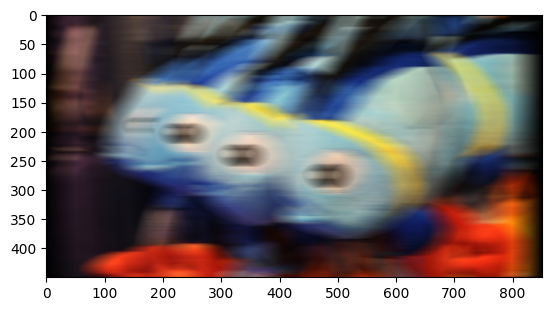

In [5]:
# 1a: Blurred Image - Conventional
blurred_img1 = np.zeros((img.shape[0], img.shape[1] + 51, img.shape[2]))
for i in range(52):
    blurred_img1[:, i:i + img.shape[1], :] += img
blurred_img1 = blurred_img1 / 52
blurred_img1_noise = blurred_img1 + gauss_noise
blurred_img1_noise = blurred_img1_noise/blurred_img1_noise.max()
plt.imshow(blurred_img1_noise)


float64


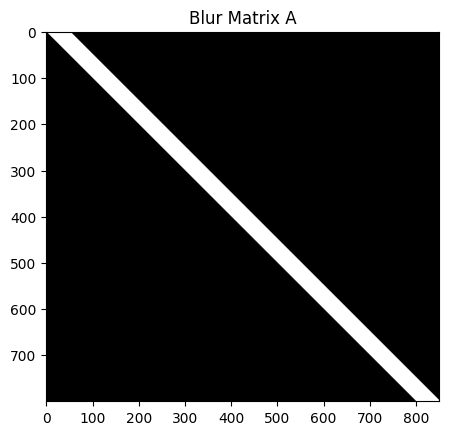

In [6]:
# 1b: Blur Matrix - Conventional
vecc = np.zeros(img.shape[1])
vecc[0] = 1 / 52
vecr_c = np.concatenate((np.ones(52), np.zeros(img.shape[1] - 1))) / 52
# print(vecr_c)

# Create the Toeplitz matrix
toep_mat = toeplitz(vecc, vecr_c)

# Extract the blur matrix
plt.imshow(toep_mat, cmap = "gray"), plt.title("Blur Matrix A")
print(toep_mat.dtype)

In [7]:
# Deblurring process
deblurred_nc_noise = np.zeros((img.shape))
deblurred_nc = np.zeros((img.shape))
deblur_matrix = toep_mat.T @ np.linalg.inv(toep_mat @ toep_mat.T) 
print(deblur_matrix.shape)
for j in range(3):  
    deblurred_nc_noise[:, :, j] = blurred_img1_noise[:, :, j] @ deblur_matrix
    deblurred_nc[:, :, j] = blurred_img1[:, :, j] @ deblur_matrix


(851, 800)


1.0, 0.0


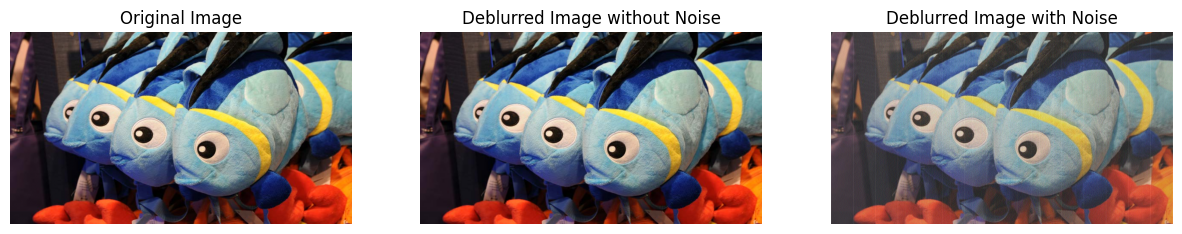

In [8]:
deblurred_nc = (deblurred_nc - deblurred_nc.min()) / (deblurred_nc.max() - deblurred_nc.min())
deblurred_nc_noise = (deblurred_nc_noise - deblurred_nc_noise.min()) / (deblurred_nc_noise.max() - deblurred_nc_noise.min())

print(f"{deblurred_nc.max()}, {deblurred_nc.min()}")
# Display the deblurred image
plt.figure(figsize = (15,6))

plt.subplot(131),plt.imshow(img/img.max()), plt.title('Original Image'), plt.axis('off')
plt.subplot(132),plt.imshow(deblurred_nc), plt.title('Deblurred Image without Noise'), plt.axis('off')  
plt.subplot(133),plt.imshow(deblurred_nc_noise), plt.title('Deblurred Image with Noise'), plt.axis('off')  
plt.show()


In [9]:
img_norm = img/255
rmse_noise = np.sqrt(np.mean((img_norm - deblurred_nc_noise) ** 2))
rmse_wo_noise = np.sqrt(np.mean((img_norm - deblurred_nc) ** 2))
print(f'RMSE with noise = {rmse_noise}')
print(f'RMSE without noise = {rmse_wo_noise}')

RMSE with noise = 0.10933836715255107
RMSE without noise = 1.8087870832770345e-12


The deblurring without noise has given a clean image where as with noise, there is change in the intensity of the deblurred image.

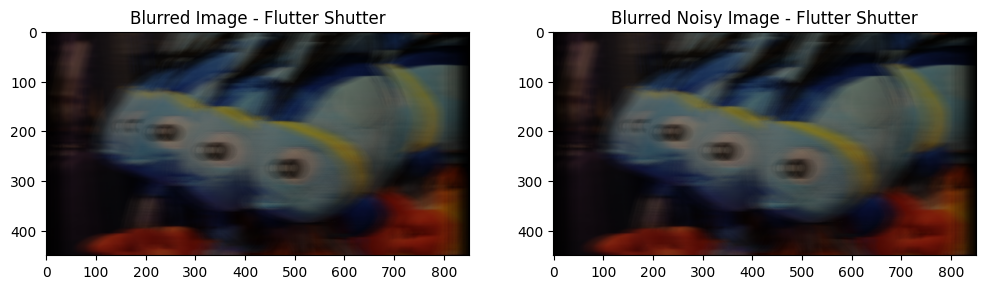

In [28]:
# 2a - Flutter Shutter Simulation
codeSeq1 = sio.loadmat('data/codeSeq.mat')['codeSeq'].flatten()  # Load the code sequence

codeSeq2 = '1010101010101010101010101010101010101010101010101010'
codeSeq2 = np.array([int(bit) for bit in codeSeq2])

# codeSeq2 = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,])
# Generate blurred image using the flutter shutter code
blurred_img2 = np.zeros((img.shape[0], img.shape[1] + 51, img.shape[2]))
for i in range(52):
    blurred_img2[:, i:i+img.shape[1], :] += img * codeSeq1[i]

blurred_img2 = blurred_img2 / 52  # Average
blurred_img2_wo_noise = blurred_img2.astype(np.uint8)
# blurred_img2 = blurred_img2/ blurred_img2.max()
blurred_img2_noise = blurred_img2 + gauss_noise  # Add Gaussian noise
blurred_img2_noise = np.clip(blurred_img2_noise, 0, 255).astype(np.uint8) 

# Displaying the blurred image
plt.figure(figsize = (12,6))
plt.subplot(121),plt.imshow(blurred_img2_wo_noise), plt.title('Blurred Image - Flutter Shutter')
plt.subplot(122),plt.imshow(blurred_img2_noise), plt.title('Blurred Noisy Image - Flutter Shutter')
plt.show()



(800, 851)


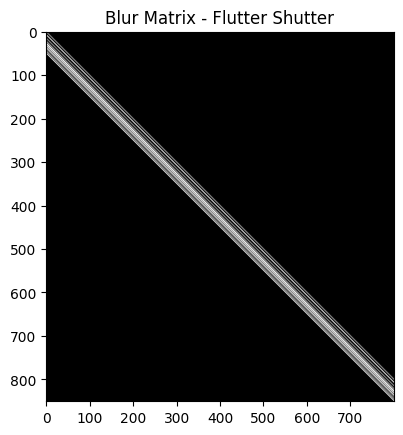

In [37]:
# 2b - Construct the blur matrix (Flutter Shutter)
vecrF = np.hstack([codeSeq1 / 52, np.zeros(img.shape[1] - 1)])
toepMat1 = toeplitz(vecc, vecrF)
print(toepMat1.shape)

# Display the blur matrix (Flutter Shutter)
plt.figure()
plt.imshow(toepMat1.T, cmap='gray')
plt.title('Blur Matrix - Flutter Shutter')
plt.show()



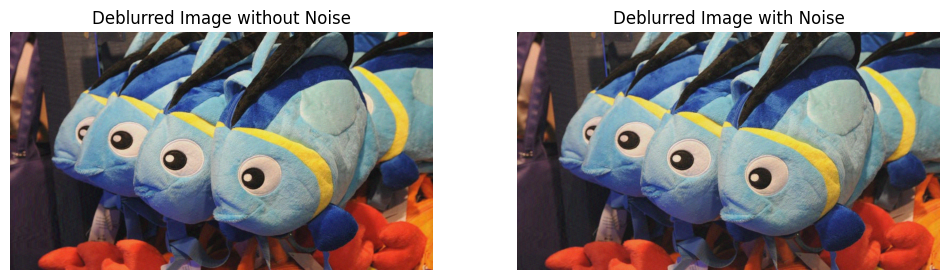

In [38]:
# Deblurring process
deblurred_noise = np.zeros((img.shape))
deblurred_wo_noise = np.zeros((img.shape))
deblur_matrix = toepMat1.T @ np.linalg.pinv(toepMat1 @ toepMat1.T) 
for j in range(3):  
    deblurred_noise[:, :, j] = blurred_img2_noise[:, :, j] @ deblur_matrix
    deblurred_wo_noise[:, :, j] = blurred_img2_wo_noise[:, :, j] @ deblur_matrix

deblurred_noise = (deblurred_noise - deblurred_noise.min()) / (deblurred_noise.max() - deblurred_noise.min())
deblurred_wo_noise = (deblurred_wo_noise - deblurred_wo_noise.min()) / (deblurred_wo_noise.max() - deblurred_wo_noise.min())
# np.clip(deblurred_nc, 0)
# Display the deblurred image
plt.figure(figsize = (12,6))
plt.subplot(121), plt.imshow(deblurred_wo_noise), plt.title('Deblurred Image without Noise'), plt.axis('off') 
plt.subplot(122), plt.imshow(deblurred_noise), plt.title('Deblurred Image with Noise'), plt.axis('off') 
plt.show()


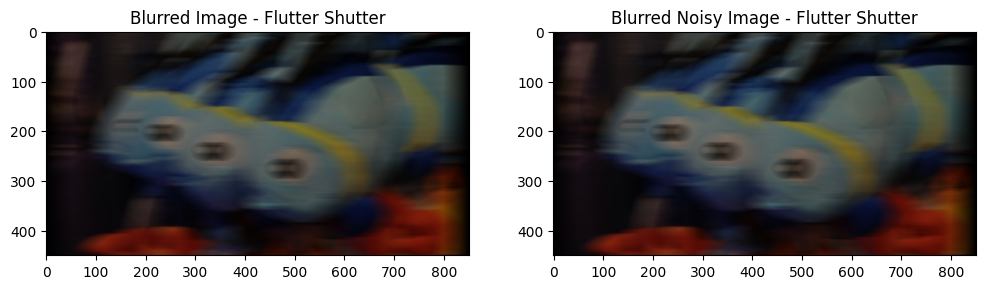

In [39]:
blurred_img3 = np.zeros((img.shape[0], img.shape[1] + 51, img.shape[2]))
for i in range(52):
    blurred_img3[:, i:i+img.shape[1], :] += img * codeSeq2[i]

blurred_img3 = blurred_img3 / 52  # Average
blurred_img3_wo_noise = blurred_img3.astype(np.uint8)
# blurred_img3 = blurred_img3/ blurred_img3.max()
blurred_img3_noise = blurred_img3 + gauss_noise  # Add Gaussian noise
blurred_img3_noise = np.clip(blurred_img3_noise, 0, 255).astype(np.uint8) 

# Displaying the blurred image
plt.figure(figsize = (12,6))
plt.subplot(121),plt.imshow(blurred_img3_wo_noise), plt.title('Blurred Image - Flutter Shutter')
plt.subplot(122),plt.imshow(blurred_img3_noise), plt.title('Blurred Noisy Image - Flutter Shutter')
plt.show()

(800, 851)


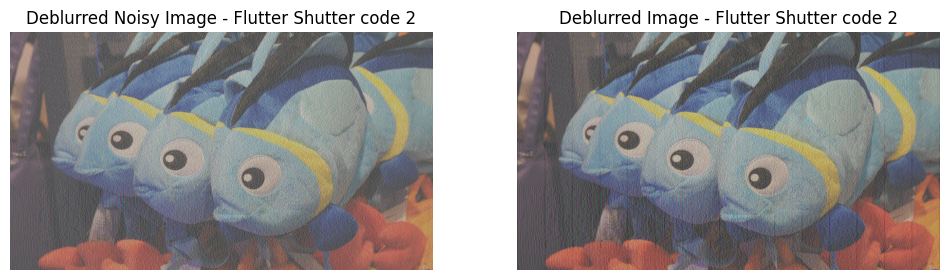

In [43]:
# 2b - Construct the blur matrix (Flutter Shutter)
vecrF = np.hstack([codeSeq2 / 52, np.zeros(img.shape[1] - 1)])
toepMat2 = toeplitz(vecc, vecrF)
blur_ac = toep_mat[:img.shape[1], :]
print(toepMat2.shape)

# Deblurring process
deblurred_nosie2 = np.zeros((img.shape))
deblurred_wo_nosie2 = np.zeros((img.shape))
deblur_matrix = toepMat2.T @ np.linalg.pinv(toepMat2 @ toepMat2.T) 
for j in range(3):  
    deblurred_nosie2[:, :, j] = blurred_img3_noise[:, :, j] @ deblur_matrix
    deblurred_wo_nosie2[:, :, j] = blurred_img3_wo_noise[:, :, j] @ deblur_matrix

deblurred_nosie2 = (deblurred_nosie2 - deblurred_nosie2.min()) / (deblurred_nosie2.max() - deblurred_nosie2.min())
deblurred_wo_nosie2 = (deblurred_wo_nosie2 - deblurred_wo_nosie2.min()) / (deblurred_wo_nosie2.max() - deblurred_wo_nosie2.min())
plt.figure(figsize= (12,6))
plt.subplot(121), plt.imshow(deblurred_nosie2), plt.title('Deblurred Noisy Image - Flutter Shutter code 2'), plt.axis('off') 
plt.subplot(122), plt.imshow(deblurred_wo_nosie2), plt.title('Deblurred Image - Flutter Shutter code 2'), plt.axis('off') 
plt.show()

on comparing the results of code flutter code 1 and flutter code 2, it is obsereved that the flutter code 2 had less brighter image as half of the time the shutter was closed. Also the noise is visible more in code 2

In [135]:
def generate_long_exposure_blur_matrix(N, exposure_duration=52):
    A_conventional = np.zeros((N + exposure_duration - 1, N))
    for i in range(N):
        A_conventional[i:i + exposure_duration, i] = 1.0  # Full exposure over 52 time steps for each pixel
    return A_conventional
conventional_data = generate_long_exposure_blur_matrix(800)

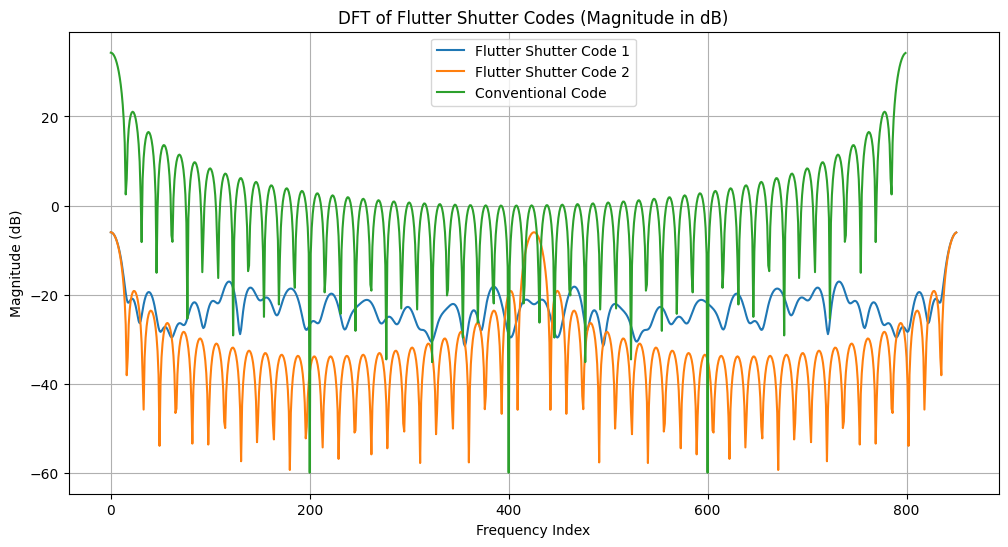

In [141]:
flutter_code1 = toepMat1.T[:, 0]
flutter_code2 = toepMat2.T[:, 0]
conventional = conventional_data.T[:,400]
# Compute the DFT of both flutter code
flutter_dft1 = np.fft.fft(flutter_code1)
flutter_dft2 = np.fft.fft(flutter_code2)
conv_dft2 = np.fft.fft(conventional)

# Compute the magnitude of the DFT 
flutter_magnitude1 = np.abs(flutter_dft1)
flutter_magnitude2 = np.abs(flutter_dft2)
conv_magnitude2 = np.abs(conv_dft2)

# Convert magnitudes to decibels
flutter_magnitude1_db = 20 * np.log10(flutter_magnitude1 + 0.001) 
flutter_magnitude2_db = 20 * np.log10(flutter_magnitude2 + 0.001)
conv_magnitude2_db = 20 * np.log10(conv_magnitude2 + 0.001)

plt.figure(figsize=(12, 6))
plt.plot(flutter_magnitude1_db, label="Flutter Shutter Code 1")
plt.plot(flutter_magnitude2_db, label="Flutter Shutter Code 2")
plt.plot(conv_magnitude2_db, label="Conventional Code")

plt.title("DFT of Flutter Shutter Codes (Magnitude in dB)")
plt.xlabel("Frequency Index")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.legend() 
plt.show()


In the DFT of the conventional method, there are many frequencies having low values and the magnitudes of many frequencies are comparable. In the flutter shutter method, the frequencies have varying magnitudes, thereby allowing certain information to be captured more than the other, which allows better deblurring. The flutter code 1 has no sudden dips like code2. Hence, it generated cleaner image than code 2.

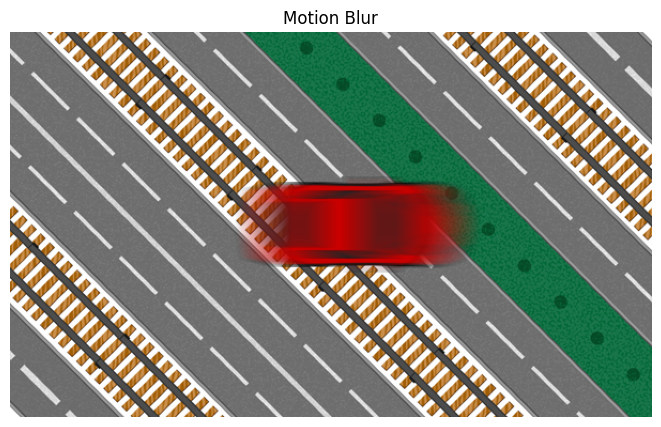

In [84]:
background_path = r'C:\Users\htic\Downloads\Computational Photography\PA2\data\background.png'
foreground_path = r'C:\Users\htic\Downloads\Computational Photography\PA2\data\redcar.png'
total_frames = 52

background_img = cv2.imread(background_path)
foreground_img = cv2.imread(foreground_path)

bg_h, bg_w = background_img.shape[:2]
fg_h, fg_w = foreground_img.shape[:2]

accumulated_image = np.zeros((bg_h, bg_w, 3), dtype=np.float32)

has_alpha = foreground_img.shape[2] == 4

for frame_num in range(total_frames):
    x_start = frame_num
    x_end = frame_num + fg_w

    if x_start >= bg_w:
        break  

    x_start = max(x_start, 0)
    x_end = min(x_end, bg_w)

    visible_fg = foreground_img[:, :x_end - x_start]

    current_frame = np.copy(background_img)

    if has_alpha:
        alpha_mask = visible_fg[:, :, 3] / 255.0  
        alpha_mask = np.expand_dims(alpha_mask, axis=-1) 
        current_frame[:fg_h, x_start:x_end] = (visible_fg[:, :, :3] * alpha_mask + current_frame[:fg_h, x_start:x_end] * (1 - alpha_mask)        )
    else:
        mask = np.any(visible_fg[:, :, :3] != 0, axis=-1)
        current_frame[:fg_h, x_start:x_end][mask] = visible_fg[:, :, :3][mask]

    accumulated_image += current_frame

# Normalize and convert the accumulated image back to uint8
blurred_image = np.clip(accumulated_image / total_frames, 0, 255).astype(np.uint8)

# Display the result
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))
plt.title('Motion Blur')
plt.axis('off')
plt.show()


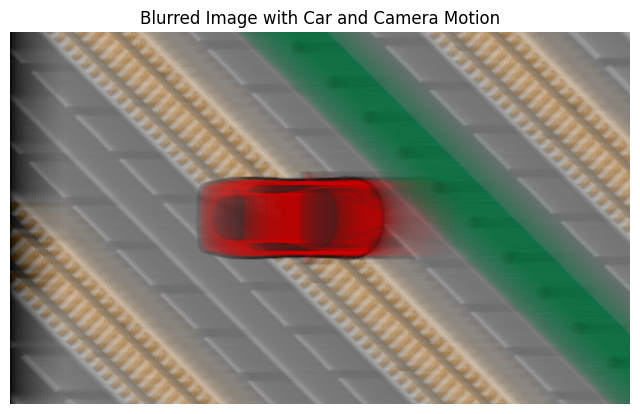

In [151]:
M, N, C = background.shape

camera_translation_data = sio.loadmat(r'C:\Users\htic\Downloads\Computational Photography\PA2\data\CameraT.mat')
camera_translations = camera_translation_data['CameraT'].flatten() 

accumulated_image = np.zeros((M, N, C), dtype=np.float32)

car_velocity_per_second = 1 
for t in range(52):
    cam_trans_x = camera_translations[t]
    
    translation_matrix_background = np.float32([[1, 0, cam_trans_x], [0, 1, 0]]) 
    translated_background = cv2.warpAffine(background, translation_matrix_background, (N, M))

    car_translation = car_velocity_per_second * t 
    relative_translation_x = cam_trans_x - car_translation

    translation_matrix_car = np.float32([[1, 0, relative_translation_x], [0, 1, 0]]) 
    translated_car = cv2.warpAffine(foreground_img, translation_matrix_car, (N, M))

    frame = translated_background.copy()
    non_black_mask = np.any(translated_car != [0, 0, 0], axis=-1)

    frame[non_black_mask] = translated_car[non_black_mask]

    accumulated_image += frame.astype(np.float32)

blurred_image4 = (accumulated_image / 52).astype(np.uint8)

cv2.imwrite('outputs/ques_3b.png', blurred_image4)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(blurred_image4, cv2.COLOR_BGR2RGB))
plt.title("Blurred Image with Car and Camera Motion")
plt.axis('off')
plt.show()


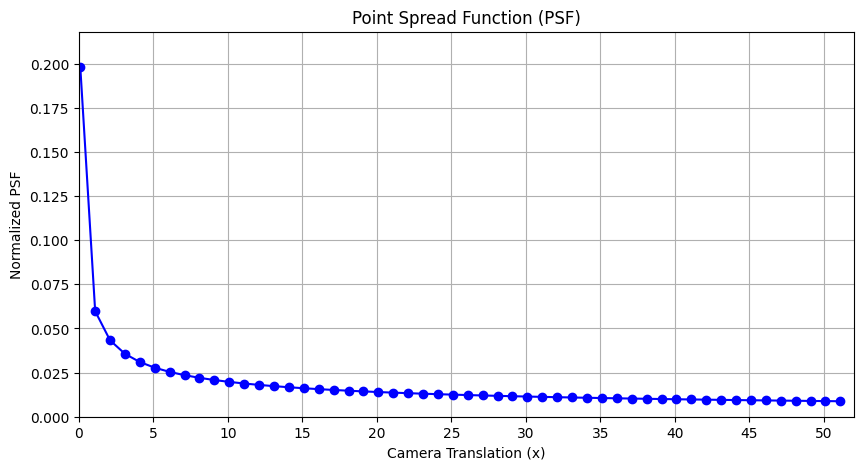

In [152]:
# Constants
a = 1 / 13
x_values = np.arange(0.1, 52, 1)  # x from 0.1 to 51

# Calculate PSF
psf_values = 1 / np.sqrt(a * x_values)

# Normalize the PSF
normalized_psf = psf_values / np.sum(psf_values)

# Plot the PSF
plt.figure(figsize=(10, 5))
plt.plot(x_values, normalized_psf, marker='o', linestyle='-', color='b')
plt.title('Point Spread Function (PSF)')
plt.xlabel('Camera Translation (x)')
plt.ylabel('Normalized PSF')
plt.grid()
plt.xlim(0, 52)
plt.ylim(0, np.max(normalized_psf) * 1.1)
plt.xticks(np.arange(0, 52, 5))
plt.savefig('outputs/ques_3d.png', dpi=300, bbox_inches='tight')
plt.show()

When using a static camera, only the moving object appears blurred, while the background remains unchanged. In contrast, camera movement during exposure causes both the background and the moving object to blur, yet it often results in clearer features of the moving object. The camera motion modifies the blur matrix, creating a more nuanced effect. As the object's velocity increases, the blur to the right of the car intensifies, and the transparency of the car region increases due to the wider spread of its positions.

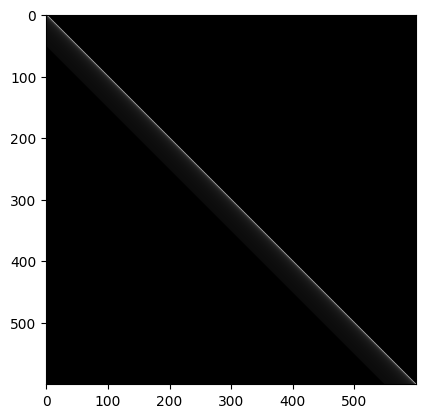

In [170]:
# Generate the PSF (Point Spread Function)
x_values = np.concatenate(([0.1], np.arange(1, 52)))
a = 1 / 13
psf_values = 1 / np.sqrt(a * x_values)
psf_values_normalized = psf_values / np.sum(psf_values)

# Load the blurred image
blurred_image = blurred_image #cv2.imread('blurred_image_camera_motion.png').astype(np.float32) / 255.0
M, N, C = blurred_image.shape

# Create the blur matrix (Toeplitz matrix)
psf_length = len(psf_values_normalized)
first_column = np.concatenate((psf_values_normalized, np.zeros(N - psf_length)))
first_row = np.zeros(N)
toepMat3 = toeplitz(first_column, first_row)
plt.imshow(toepMat3, cmap="gray")

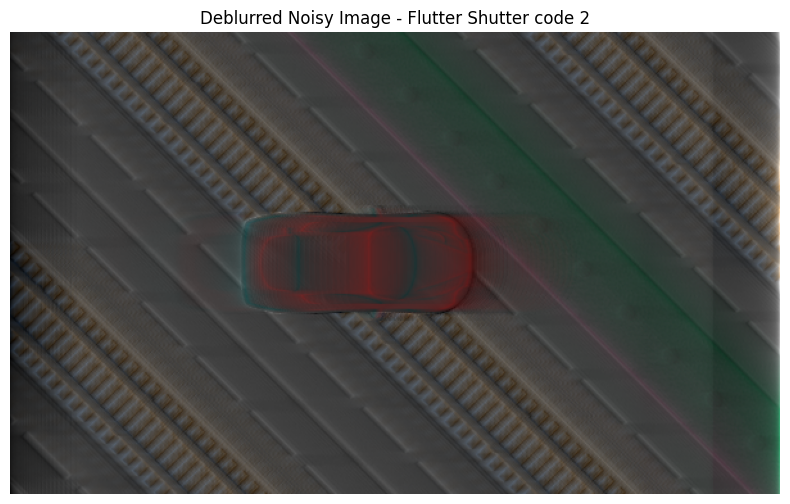

In [171]:
# Deblurring process
deblurred_nosie2 = np.zeros((blurred_image4.shape))
deblur_matrix = toepMat3.T @ np.linalg.pinv(toepMat3 @ toepMat3.T) 
for j in range(3):  
    deblurred_nosie2[:, :, j] = blurred_image4[:, :, j] @ deblur_matrix

# print(deblurred_nosie2.max())
deblurred_nosied = ((deblurred_nosie2 - deblurred_nosie2.min()) / (deblurred_nosie2.max() - deblurred_nosie2.min())*255).astype(np.uint8)
deblurred_nosied = cv2.cvtColor(deblurred_nosied, cv2.COLOR_BGR2RGB)
plt.figure(figsize= (12,6))
plt.imshow(deblurred_nosied), plt.title('Deblurred Noisy Image - Flutter Shutter code 2'), plt.axis('off') 
plt.show()